In [1]:
# main.py
"""
Purpose of script:
    - Process .laz tiles into DTM .geotif images, and process these DTM .geotif images into relief or hillshade visualisations.
    - Prejudice towards using pdal for .laz -> DTM processing and Relief Visualization Toolbox (`rvt_py`) for DTM -> visualizations.
Current status:
    - In development (fragile)
"""

# import top-level packages
import os
import sys
import json
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio

import earthaccess
import pdal
import rvt
import laspy


# compute absolute path to the project root's src/
sys.path.insert(0, os.path.join(os.getcwd(), "src"))

# import project specific (src/project_utils/...) packages #
from project_utils import config as proj_config
from project_utils import io as proj_io
from project_utils import geo as proj_geo
from project_utils import lidar as proj_lidar
from project_utils import raster as proj_raster
from project_utils import satellite as proj_satellite
from project_utils import vis as proj_vis
from project_utils import scratch as proj_scratch

# auto-reload any module that changes on disk
%load_ext autoreload
%autoreload
# %reload_ext autoreload

In [2]:
def test_setup(path_to_config):
    proj_scratch.test_imports()


path_to_config = "main/config.yml"

# test setup
test_setup(path_to_config)

# get config from config.yml
config = proj_config.Config(path_to_config)

proj_io.authenticate_earthaccess()


All core imports succeeded!
Library         | Version   
----------------------------
rasterio        | 1.4.3     
pdal            | 3.4.5     
 
[io] Authenticating with earthaccess...
[io] Authenticated: True


True

In [3]:
# download dataset metadata and csv
concept_id = config.get("dataset", "concept_id")
# doi = config.get("dataset", "doi")
path_to_csv_dir = config.get("paths", "dataset_csv")

# metadata = earthaccess.search_datasets(doi=doi)[0]

path_to_csv = proj_io.download_earthaccess_dataset_csv(
    concept_id,
    path_to_csv_dir,
    overwrite=False
)

index = 28
df = pd.read_csv(path_to_csv)

laz_filename = df.iloc[index]["filename"]
path_to_laz = os.path.join(
    config.get("paths", "raw", "sat"),
    laz_filename
)

path_to_laz = proj_io.fetch_laz_file(
    laz_filename,
    config.get("paths", "raw", "laz"),
    verbose=False,
    overwrite=False
)

[io] Downloading dataset CSV for concept_id: C2398128915-ORNL_CLOUD


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[io] CSV downloaded: data/metadata/cms_brazil_lidar_tile_inventory.csv


In [4]:
img = proj_satellite.fetch_esri_from_row(
    df,
    laz_filename,
    save_path=os.path.join(
        config.get("paths", "raw", "sat"),
        laz_filename.split('.')[0] + '.png'
    )
)

[satellite] Downloading ESRI image for AND_A01_2013_laz_11.laz...
[satellite] Saved: data/raw/tiles/sat/AND_A01_2013_laz_11.png


In [5]:
min_lat = float(df.iloc[index]["min_lat"])
max_lat = float(df.iloc[index]["max_lat"])
min_lon = float(df.iloc[index]["min_lon"])
max_lon = float(df.iloc[index]["max_lon"])

centre = ((min_lat + max_lat)/2, (min_lon + max_lon)/2)

In [6]:
# title = f"ESRI Satellite image of\n{laz_filename}"
title = f"""ESRI Satellite image of
{laz_filename}
centre coord (lat, lon): {centre[0]:.4f}, {centre[1]:.4f}"""

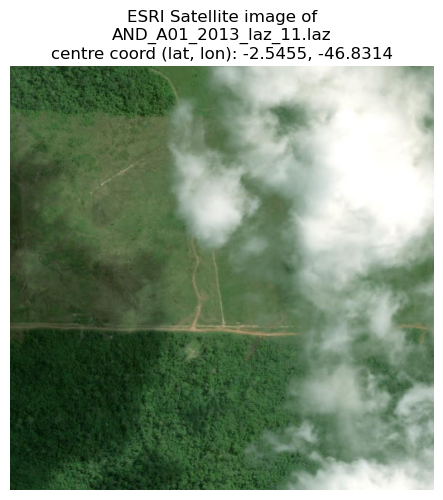

centre coord (lat, lon): -2.5455, -46.8314


In [7]:
plt.imshow(img)
plt.title(title)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()  # Required to actually display the image in a .py script
print(f"centre coord (lat, lon): {centre[0]:.4f}, {centre[1]:.4f}")

In [8]:
path_to_laz

PosixPath('data/raw/tiles/laz/AND_A01_2013_laz_11.laz')

In [30]:
import laspy
from collections import Counter

filename = path_to_laz  # <-- change to your LAZ file

# Open and read point classifications
with laspy.open(filename) as fh:
    las = fh.read()
    classifications = las.classification

# Count occurrences
counts = Counter(classifications)
total = sum(counts.values())

# Classification names (ASPRS standard codes)
class_names = {
    0: "Created, never classified",
    1: "Unclassified",
    2: "Ground",
    3: "Low Vegetation",
    4: "Medium Vegetation",
    5: "High Vegetation",
    6: "Building",
    7: "Low Point (noise)",
    8: "Model Key-point",
    9: "Water",
    10: "Reserved",
    11: "Reserved",
    12: "Overlap Points",
    13: "Reserved",
    14: "Reserved",
    15: "Reserved"
}

# Prepare output
header = f"{'Class Code':<10} {'Count':>10} {'Percent':>10}  {'Name'}"
print(header)
print('-' * len(header))
for class_code, count in sorted(counts.items()):
    percent = count / total * 100
    name = class_names.get(class_code, 'Unknown')
    print(f"{class_code:<10} {count:>10} {percent:9.2f}%  {name}")

# Print total for reference
print('-' * len(header))
print(f"{'TOTAL':<10} {total:>10} {100:9.2f}%")

Class Code      Count    Percent  Name
--------------------------------------
2             1285320      7.03%  Ground
3             4896187     26.77%  Low Vegetation
4             2295332     12.55%  Medium Vegetation
5             9814438     53.66%  High Vegetation
--------------------------------------
TOTAL        18291277    100.00%


In [31]:
proj_lidar.print_laz_classification_counts(path_to_laz)

Class Code      Count    Percent  Name
--------------------------------------
2             1285320      7.03%  Ground
3             4896187     26.77%  Low Vegetation
4             2295332     12.55%  Medium Vegetation
5             9814438     53.66%  High Vegetation
--------------------------------------
TOTAL        18291277    100.00%


In [13]:
os.makedirs("data/processed/dem", exist_ok=True)

temp = proj_lidar.laz_to_dtm(
    "data/raw/tiles/laz/AND_A01_2013_laz_11.laz",
    "data/processed/dem/AND_A01_2013_laz_11.tif",
    "config/pdal_pipelines/new_dem.json"
)


[lidar] Loading pipeline template from: config/pdal_pipelines/new_dem.json
[lidar] Building PDAL pipeline from template...
[lidar] Running PDAL pipeline with 3 stages...
[lidar] Pipeline definition: {
  "pipeline": [
    {
      "type": "readers.las",
      "filename": "data/raw/tiles/laz/AND_A01_2013_laz_11.laz"
    },
    {
      "type": "filters.range",
      "limits": "Z[0:1000]"
    },
    {
      "type": "writers.gdal",
      "filename": "data/processed/dem/AND_A01_2013_laz_11.tif",
      "resolution": 2.0,
      "data_type": "float32",
      "nodata": -9999
    }
  ]
} ...
[lidar] Starting PDAL execution...
[lidar] PDAL complete, 18291277 points processed.


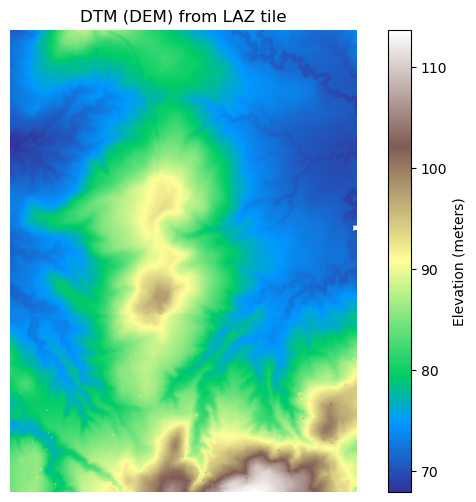

In [15]:
import rasterio
import matplotlib.pyplot as plt

# Path to your output DEM
dem_path = "data/processed/dem/AND_A01_2013_laz_11.tif"

with rasterio.open(dem_path) as src:
    arr = src.read(1)
    profile = src.profile

# Example: mask anything outside plausible range
arr_clean = np.where((arr > 0) & (arr < 1000), arr, np.nan)

# with rasterio.open(dem_path) as src:
#     arr = src.read(1)  # Read the first band
plt.figure(figsize=(8,6))
im = plt.imshow(arr_clean, cmap='terrain')
plt.colorbar(im, label='Elevation (meters)')
plt.title("DTM (DEM) from LAZ tile")
plt.axis('off')
plt.show()

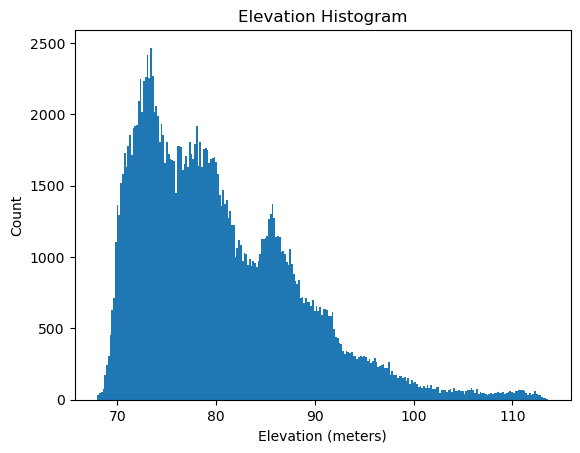

In [17]:
plt.hist(arr_clean.flatten(), bins=256)
plt.title("Elevation Histogram")
plt.xlabel("Elevation (meters)")
plt.ylabel("Count")
plt.show()

In [18]:
import rvt.default

TypeError: Invalid shape (6, 501, 376) for image data

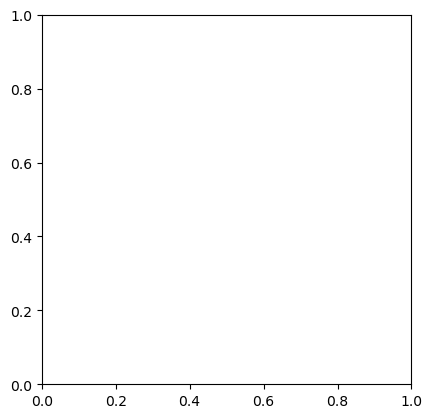

In [21]:
dict_dem = rvt.default.get_raster_arr(dem_path)
dem_arr = dict_dem["array"]  # numpy array of DEM
dem_resolution = dict_dem["resolution"]
dem_res_x = dem_resolution[0]  # resolution in X direction
dem_res_y = dem_resolution[1]  # resolution in Y direction
dem_no_data = dict_dem["no_data"]

plt.imshow(dem_arr, cmap='gray')  # show DEM